To test the statevector permutation problem
using AER toy example

In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters
from qiskit.quantum_info import state_fidelity

import quantum_gates


# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
    

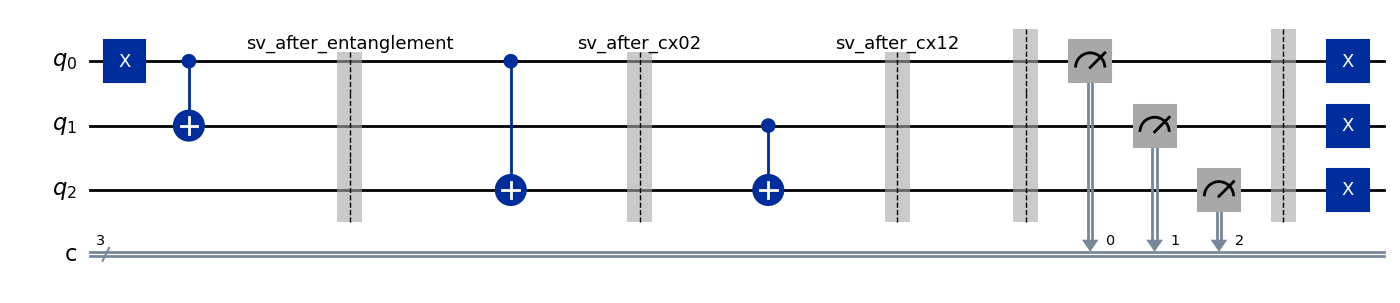

In [2]:
# --- Define a circuit ---
N_q = 3
N_m = N_q  # number of measured qubits
qc = QuantumCircuit(N_q, N_m)

# Prepare |01>
qc.x(0)
qc.cx(0,1)

qc.save_statevector(label="sv_after_entanglement")
qc.cx(0,2)

qc.save_statevector(label="sv_after_cx02")
qc.cx(1,2)

qc.save_statevector(label="sv_after_cx12")

# Measure
qc.barrier()  #
qc.measure(range(N_q), range(N_m))
qc.barrier()  #
qc.x(range(N_q))  #


qc.draw('mpl')

Might need the device parameters to transpile

In [3]:
# Simulate with Aer
shots = 1
sim = AerSimulator(method="statevector")
result_orig = sim.run(qc, shots=shots).result()

sv_ent_orig = result_orig.data()["sv_after_entanglement"]
sv_cx02_orig = result_orig.data()["sv_after_cx02"]
sv_cx12_orig = result_orig.data()["sv_after_cx12"]

counts = result_orig.get_counts()

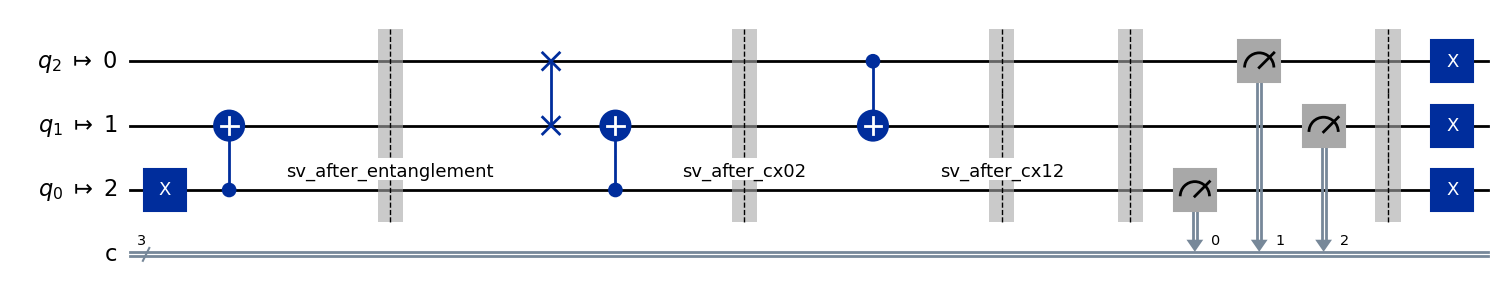

In [4]:
transpiled_circ = transpile(qc, coupling_map=[[0,1],[1,0],[1,2],[2,1]], optimization_level=2)
transpiled_circ.draw('mpl')

In [5]:
result_trans = sim.run(transpiled_circ, shots=shots).result()

sv_ent_trans = result_trans.data()["sv_after_entanglement"]
sv_cx02_trans = result_trans.data()["sv_after_cx02"]
sv_cx12_trans = result_trans.data()["sv_after_cx12"]

counts_trans = result_trans.get_counts()

In [6]:
# ---------------------------------------------------------
# 3. Print statevectors
# ---------------------------------------------------------
print('--- Statevectors ---')
print("Original entanglement SV:\n", sv_ent_orig)
print("Transpiled entanglement SV:\n", sv_ent_trans)
print('-------\n')

print("Original CX(0,2) SV:\n", sv_cx02_orig)
print("Transpiled CX(0,2) SV:\n", sv_cx02_trans)
print('-------\n')

print("Original CX(1,2) SV:\n", sv_cx12_orig)
print("Transpiled CX(1,2) SV:\n", sv_cx12_trans)
print('-------\n')

# ---------------------------------------------------------
# 4. Compute fidelities
# ---------------------------------------------------------
print("\n--- Fidelities between transpileld vs original Circ Simulation ---")
F_ent = state_fidelity(sv_ent_orig,  sv_ent_trans)
F_cx02 = state_fidelity(sv_cx02_orig, sv_cx02_trans)
F_cx12 = state_fidelity(sv_cx12_orig, sv_cx12_trans)

print("\nFidelity after entanglement:   ", F_ent)
print("Fidelity after CX(0,2):       ", F_cx02)
print("Fidelity after CX(1,2):       ", F_cx12)

--- Statevectors ---
Original entanglement SV:
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Transpiled entanglement SV:
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
-------

Original CX(0,2) SV:
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j],
            dims=(2, 2, 2))
Transpiled CX(0,2) SV:
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j],
            dims=(2, 2, 2))
-------

Original CX(1,2) SV:
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Transpiled CX(1,2) SV:
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
-------


--- Fidelities between transpileld vs original Circ Simulation ---

Fidelity after entang

Permutation Work   

In [7]:
initial = transpiled_circ.layout.initial_index_layout()
print(initial)

final = transpiled_circ.layout.final_index_layout()
print(final)

[2, 1, 0]
[2, 0, 1]


In [8]:
save_instr_qubit_orders = []

for inst, qargs, cargs in transpiled_circ.data:
    if inst.name == "save_statevector":

        # Physical qubit indices for the SaveStatevector instruction
        phys_order = [transpiled_circ.find_bit(q).index for q in qargs]

        save_instr_qubit_orders.append(phys_order)


order_ent, order_cx02, order_cx12 = save_instr_qubit_orders
print(save_instr_qubit_orders)

[[2, 1, 0], [2, 0, 1], [2, 0, 1]]


C:\Users\npace\AppData\Local\Temp\ipykernel_17636\4201295447.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in transpiled_circ.data:


In [9]:
def permute_sv(sv, qubit_order):
    """
    sv: numpy statevector (complex array)
    qubit_order: list where qubit_order[logical] = physical qubit index
                 in the ordering used by the save instruction

    This restores the statevector into logical [0,1,2,...] order.
    """
    n = len(qubit_order)
    new_sv = np.zeros_like(sv)

    for idx in range(len(sv)):
        # physical bits in the statevector as output by Aer
        phys_bits = [(idx >> i) & 1 for i in range(n)]

        # reorder into logical order
        log_bits = [ phys_bits[qubit_order[logical]] for logical in range(n) ]

        # compute new index in logical basis ordering
        new_idx = sum(log_bits[i] << i for i in range(n))

        new_sv[new_idx] = sv[idx]

    return new_sv


In [10]:
# --- permute each statevector correctly ---
sv_logical_ent  = permute_sv(sv_ent_trans,  order_ent)
sv_logical_cx02 = permute_sv(sv_cx02_trans, order_cx02)
sv_logical_cx12 = permute_sv(sv_cx12_trans, order_cx12)

C:\Users\npace\AppData\Local\Temp\ipykernel_17636\50518544.py:12: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for idx in range(len(sv)):


In [11]:

# --- compute fidelities ---
print('Permuted transpilled ent SV: ', sv_logical_ent)
print("Fidelity entanglement =", state_fidelity(sv_ent_orig, sv_logical_ent))
print('---')

print('Permuted transpilled cx02 SV: ', sv_logical_cx02)
print("Fidelity CX(0,2)      =", state_fidelity(sv_cx02_orig, sv_logical_cx02))
print('---')

print('Permuted transpilled cx12 SV: ', sv_logical_cx12)
print("Fidelity CX(1,2)      =", state_fidelity(sv_cx12_orig, sv_logical_cx12))

Permuted transpilled ent SV:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Fidelity entanglement = 1.0
---
Permuted transpilled cx02 SV:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
Fidelity CX(0,2)      = 1.0
---
Permuted transpilled cx12 SV:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Fidelity CX(1,2)      = 1.0


Original Circ Aer All clbits counts: {'011': 1}


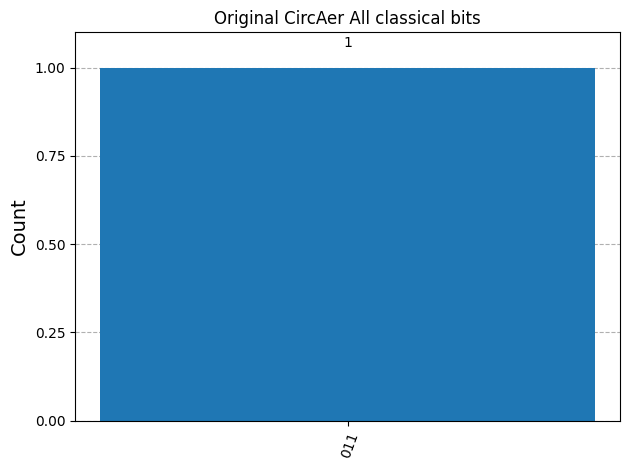

In [12]:
print("Original Circ Aer All clbits counts:", counts)
plot_histogram(counts, title="Original CircAer All classical bits")

Transpilled Circ Aer All clbits counts: {'011': 1}


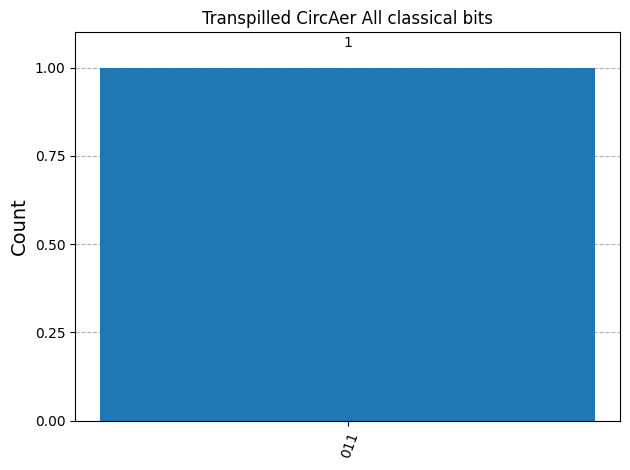

In [13]:
print("Transpilled Circ Aer All clbits counts:", counts_trans)
plot_histogram(counts_trans, title="Transpilled CircAer All classical bits")